In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import os, sys
sys.path.append(os.path.join("/home/ra43rid/torch_plnet"))
torch.set_default_device("cuda")

class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
rand_aps = APS(score_type="identity", randomized=True)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

clf_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cuda")
clf_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cuda")
clf_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cuda")
clf_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cuda")

In [13]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [71]:
from zmq import device
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import torch
from scipy.stats import kendalltau
from joblib import Parallel, delayed
torch.set_default_device("cuda")

def fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate = 0.01, num_epochs=200):
    conformities = oracle_annotator.get_conformity(torch.tensor(X_train, device="cuda"),torch.tensor(y_train,device="cuda")).detach().cpu().numpy()

    sort_idx = (-conformities).argsort(axis=0).flatten()
    X_sorted = X_train[sort_idx]
    X_sorted = X_sorted.detach().cpu().numpy()
    y_sorted = y_train[sort_idx]
    conformities_sorted = conformities[sort_idx]
    
    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    conformity_pairs = np.array([(conformities_sorted[i], conformities_sorted[j]) for i in range(len(conformities_sorted)) for j in range(i + 1, len(conformities_sorted))])
    conformity_pairs = conformity_pairs.round(6)
    mask = conformity_pairs[:,0] == conformity_pairs[:,1]
    
    X_pairs_distinct = X_pairs[~mask]
    y_pairs_distinct = y_pairs[~mask]
    X_pairs_nondistinct = X_pairs[mask]
    y_pairs_nondistinct = y_pairs[mask]
    X_pairs_nondistinct_swp = X_pairs_nondistinct[:,::-1]
    y_pairs_nondistinct_swp = y_pairs_nondistinct[:,::-1]

    X_pairs_augmented = np.vstack((X_pairs_distinct, X_pairs_nondistinct, X_pairs_nondistinct_swp))
    y_pairs_augmented = np.vstack((y_pairs_distinct, y_pairs_nondistinct, y_pairs_nondistinct_swp))

    y_pairs_augmented = np.expand_dims(y_pairs_augmented,axis=-1)

    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_pairs_augmented, y_pairs_augmented)
    pair_loader = DataLoader(ds, batch_size=64)
    # ds_val = LabelPairDataset()
    # ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
    # val_loader = DataLoader(ds_val, batch_size=64)
    model = LabelRankingModel(input_dim=generator.n_features, hidden_dims=2*[10*generator.n_features], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
    model.num_classes = generator.n_classes
    model._fit(pair_loader, val_loader=None, num_epochs=num_epochs, learning_rate=learning_rate, patience=num_epochs, verbose=True)
    return model

import numpy as np
import torch
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import kendalltau
def train_model(X_train, y_train, oracle_annotator, generator, learning_rate, num_epochs):
    """Trains a model with the given dataset and oracle."""
    return fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate=learning_rate, num_epochs=num_epochs)

def evaluate_model(model, oracle, name, X_test, y_test, taus, gammas):
    """Evaluates the trained model and computes correlation scores."""
    skills = np.take_along_axis(
        model.predict_class_skills(X_test),
        y_test[:, np.newaxis].detach().cpu().numpy(),
        axis=1
    )
    conformities = oracle.get_conformity(torch.tensor(X_test,device="cuda"), torch.tensor(y_test,device="cuda")).detach().cpu().numpy()
    
    tau_corr, _ = kendalltau(skills, conformities)
    gamma_corr = goodman_kruskal_gamma(skills, conformities)

    taus[name].append(tau_corr)
    gammas[name].append(gamma_corr)


def conduct_oracle_experiment(num_instances_to_check, generator, learning_rate=0.01, num_epochs=250):
    """Conducts an oracle experiment with parallelized training and evaluation."""
    
    oracle_annotator_aps = OracleAnnotator(generator=generator, score=aps)
    oracle_annotator_lac = OracleAnnotator(generator=generator, score=lac)
    oracle_annotator_rand_aps = OracleAnnotator(generator=generator, score=rand_aps)

    X_test, y_test = generator.generate_data(n_samples=100)
    X_test, y_test = X_test.to("cuda"), y_test.to("cuda")
    taus = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}
    gammas = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_train = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_train = np.tile(generator.classes_.detach().cpu().numpy(), num_instances)

        # --- Parallel Model Training ---
        models = Parallel(n_jobs=1, backend="loky")(
            delayed(train_model)(X_train, y_train, oracle, generator, learning_rate, num_epochs)
            for oracle in [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps]
        )
        model_lac, model_aps, model_rand_aps = models

        models = [model_lac, model_aps, model_rand_aps]
        oracles = [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps]
        names = ["lac", "aps", "rand_aps"]

        # --- Parallel Model Evaluation ---
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(evaluate_model, model, oracle, name, X_test, y_test, taus, gammas)
                for model, oracle, name in zip(models, oracles, names)
            ]
            for future in futures:
                future.result()  # Ensure completion

        skills_from_model = model_lac(X_test)
        own_lac = torch.take_along_dim(skills_from_model, y_test.unsqueeze(-1), dim=1).detach().cpu().numpy()
        y_test = torch.tensor(y_test, device="cuda")
        skills_from_model = -skills_from_model
        skills_from_model = (skills_from_model - skills_from_model.min()) / (skills_from_model.max() - skills_from_model.min()) 
        own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        aps_scores = oracle_annotator_aps.get_conformity(X_test, y_test).detach().cpu().numpy()

        tau_corr, p_value = kendalltau(own_aps, aps_scores)
        gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        taus["own_aps"].append(tau_corr)
        gammas["own_aps"].append(gamma_corr)
        # randomized APS reconstructed
        own_rand_aps = rand_aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
        rand_aps_scores = oracle_annotator_rand_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
        tau_corr, p_value = kendalltau(own_rand_aps, rand_aps_scores)
        gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        taus["own_rand_aps"].append(tau_corr)
        gammas["own_rand_aps"].append(gamma_corr)


    return taus, gammas

In [ ]:
clf = clf_2d_2c
num_instances=50
X_gen, _ = clf.generate_data(n_samples=num_instances)
X_train = X_gen.repeat_interleave(clf.n_classes, dim=0)
y_train = np.tile(clf.classes_.detach().cpu().numpy(), num_instances)
oa_aps = OracleAnnotator(aps,clf)
oa_lac = OracleAnnotator(lac,clf)
model_lac = fit_model_with_all_pairs(X_train, y_train, oa_lac, clf, learning_rate=0.01, num_epochs=500)

X_test, y_test = clf.generate_data(100)

skills_from_model = model_lac(X_test)
y_test = torch.tensor(y_test, device="cuda")
skills_from_model = skills_from_model - skills_from_model.min() / (skills_from_model.max() - skills_from_model.min())
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
y_test = torch.tensor(y_test, device="cuda")
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
# own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
aps_scores = oa_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
tau_corr, p_value = kendalltau(own_aps, aps_scores)

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\torch\utils\_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch 1/250
  Train Loss: 0.0084
Epoch 2/250
  Train Loss: 0.0051
Epoch 3/250
  Train Loss: 0.0026
Epoch 4/250
  Train Loss: 0.0021
Epoch 5/250
  Train Loss: 0.0018
Epoch 6/250
  Train Loss: 0.0017
Epoch 7/250
  Train Loss: 0.0016
Epoch 8/250
  Train Loss: 0.0015
Epoch 9/250
  Train Loss: 0.0015
Epoch 10/250
  Train Loss: 0.0014
Epoch 11/250
  Train Loss: 0.0014
Epoch 12/250
  Train Loss: 0.0014
Epoch 13/250
  Train Loss: 0.0013
Epoch 14/250
  Train Loss: 0.0013
Epoch 15/250
  Train Loss: 0.0012
Epoch 16/250
  Train Loss: 0.0012


KeyboardInterrupt: 

In [70]:
skills_from_model = model_lac(X_test)
own_lac = torch.take_along_dim(skills_from_model, y_test.unsqueeze(-1), dim=1).detach().cpu().numpy()
y_test = torch.tensor(y_test, device="cuda")
skills_from_model = -skills_from_model
skills_from_model = (skills_from_model - skills_from_model.min()) / (skills_from_model.max() - skills_from_model.min()) 
own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
# own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
aps_scores = oa_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
lac_scores = oa_lac.get_conformity(X_test, y_test).detach().cpu().numpy()
print("lac",kendalltau(own_lac, lac_scores)) 
print("aps",kendalltau(own_aps, aps_scores)) 

lac SignificanceResult(statistic=0.9777777777777779, pvalue=4.2199310649771926e-47)
aps SignificanceResult(statistic=0.9430407174812553, pvalue=5.510357625896526e-43)


In [62]:
skills_from_model = skills_from_model - skills_from_model.min()


tensor(92.5673, device='cuda:0', grad_fn=<MaxBackward1>)

tau lac SignificanceResult(statistic=0.9777777777777779, pvalue=4.2199310649771926e-47)
tau aps SignificanceResult(statistic=0.8570386819021045, pvalue=7.445278009421358e-36)
gamma lac 0.9777777777777777
gamma aps 0.8681592039800995


/tmp/ipykernel_30943/519797903.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_30943/519797903.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


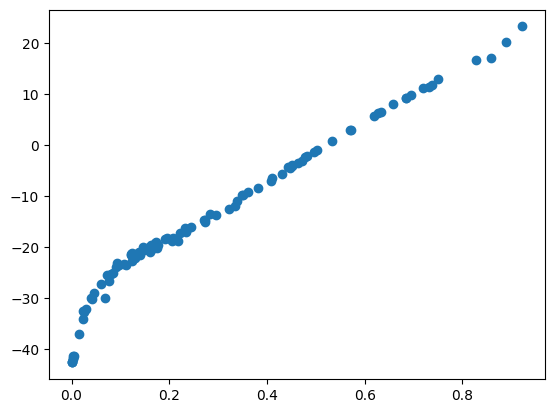

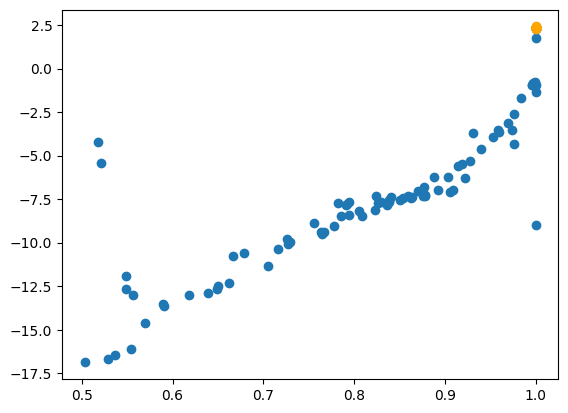

In [14]:
X_test, y_test = clf.generate_data(100)
y_test = y_test.detach().numpy()
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
print("tau lac", kendalltau(conformity_scores_lac, skills_lac))
print("tau aps",kendalltau(conformity_scores_aps, skills_aps))
print("gamma lac", goodman_kruskal_gamma(conformity_scores_lac, skills_lac))
print("gamma aps", goodman_kruskal_gamma(conformity_scores_aps, skills_aps))
plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
plt.scatter(conformity_scores_aps, skills_aps)
plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

In [22]:
# X_train, y_train = make_classification(
#     n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
# )

clf = clf_2d_2c

clf.fit(None, None)
num_instances_to_check = np.linspace(10,100,5).astype(int)
# num_instances_to_check = [40]

taus, gammas = conduct_oracle_experiment(num_instances_to_check=num_instances_to_check,generator=clf,learning_rate=0.01, num_epochs=1000)


c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\torch\utils\_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch 1/1000
  Train Loss: 0.2335
Epoch 2/1000
  Train Loss: 0.2261
Epoch 3/1000
  Train Loss: 0.2224
Epoch 4/1000
  Train Loss: 0.2184
Epoch 5/1000
  Train Loss: 0.2132
Epoch 6/1000
  Train Loss: 0.2072
Epoch 7/1000
  Train Loss: 0.2004
Epoch 8/1000
  Train Loss: 0.1921
Epoch 9/1000
  Train Loss: 0.1822
Epoch 10/1000
  Train Loss: 0.1709
Epoch 11/1000
  Train Loss: 0.1585
Epoch 12/1000
  Train Loss: 0.1454
Epoch 13/1000
  Train Loss: 0.1322
Epoch 14/1000
  Train Loss: 0.1195
Epoch 15/1000
  Train Loss: 0.1079
Epoch 16/1000
  Train Loss: 0.0977
Epoch 17/1000
  Train Loss: 0.0890
Epoch 18/1000
  Train Loss: 0.0817
Epoch 19/1000
  Train Loss: 0.0757
Epoch 20/1000
  Train Loss: 0.0707
Epoch 21/1000
  Train Loss: 0.0664
Epoch 22/1000
  Train Loss: 0.0628
Epoch 23/1000
  Train Loss: 0.0598
Epoch 24/1000
  Train Loss: 0.0572
Epoch 25/1000
  Train Loss: 0.0550
Epoch 26/1000
  Train Loss: 0.0531
Epoch 27/1000
  Train Loss: 0.0515
Epoch 28/1000
  Train Loss: 0.0500
Epoch 29/1000
  Train Loss: 0

/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_30943/1993796645.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


Epoch 1/1000
  Train Loss: 0.0115
Epoch 2/1000
  Train Loss: 0.0102
Epoch 3/1000
  Train Loss: 0.0070
Epoch 4/1000
  Train Loss: 0.0042
Epoch 5/1000
  Train Loss: 0.0032
Epoch 6/1000
  Train Loss: 0.0027
Epoch 7/1000
  Train Loss: 0.0025
Epoch 8/1000
  Train Loss: 0.0023
Epoch 9/1000
  Train Loss: 0.0021
Epoch 10/1000
  Train Loss: 0.0020
Epoch 11/1000
  Train Loss: 0.0019
Epoch 12/1000
  Train Loss: 0.0019
Epoch 13/1000
  Train Loss: 0.0018
Epoch 14/1000
  Train Loss: 0.0017
Epoch 15/1000
  Train Loss: 0.0017
Epoch 16/1000
  Train Loss: 0.0016
Epoch 17/1000
  Train Loss: 0.0016
Epoch 18/1000
  Train Loss: 0.0015
Epoch 19/1000
  Train Loss: 0.0015
Epoch 20/1000
  Train Loss: 0.0014
Epoch 21/1000
  Train Loss: 0.0014
Epoch 22/1000
  Train Loss: 0.0014
Epoch 23/1000
  Train Loss: 0.0014
Epoch 24/1000
  Train Loss: 0.0013
Epoch 25/1000
  Train Loss: 0.0013
Epoch 26/1000
  Train Loss: 0.0013
Epoch 27/1000
  Train Loss: 0.0012
Epoch 28/1000
  Train Loss: 0.0012
Epoch 29/1000
  Train Loss: 0

In [ ]:
tau_corrs_own_aps = []
gamma_corrs_own_aps = []
oracle_annotator = OracleAnnotator(generator=clf, score=aps)

for model in models_LAC:
    model.eval()
    # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
    X_test, y_test = clf.generate_data(n_samples=100)
    # X_test = X_gen.repeat_interleave(3, dim=0)
    # y_test = np.tile(generator.classes_, 100)
    skills_from_model = model(X_test)
    own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().numpy()
    # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
    aps_scores = oracle_annotator.get_conformity(X_test, y_test)
    tau_corr, p_value = kendalltau(own_aps, aps_scores)
    tau_corrs_own_aps.append(tau_corr)
    gamma_corr_own_aps = goodman_kruskal_gamma(own_aps,aps_scores)
    print(gamma_corr_own_aps)
    gamma_corrs_own_aps.append(gamma_corr_own_aps)


/tmp/ipykernel_8993/3891373539.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().numpy()


0.17248632730332353
0.31822863027806386
0.2699874424445375
0.10511785941813548
0.43529411764705883


In [ ]:
tau_corrs_own_aps = []
gamma_corrs_own_aps = []
oracle_annotator = OracleAnnotator(generator=clf, score=aps)

for model in models_LAC:
    model.eval()
    # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
    X_test, y_test = clf.generate_data(n_samples=100)
    # X_test = X_gen.repeat_interleave(3, dim=0)
    # y_test = np.tile(generator.classes_, 100)
    skills_from_model = model(X_test)
    skills_from_model = -skills_from_model
    skills_from_model -= skills_from_model.min()
    skills_from_model /= (skills_from_model.max() - skills_from_model.min())
    # skills_from_model = (skills_from_model - skills_from_model.min()) / (skills_from_model.max() - skills_from_model.min()) +500
    own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().numpy()
    # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
    aps_scores = oracle_annotator.get_conformity(X_test, y_test)
    print(own_aps)
    print(aps_scores)
    tau_corr, p_value = kendalltau(own_aps, aps_scores)
    tau_corrs_own_aps.append(tau_corr)
    gamma_corr_own_aps = goodman_kruskal_gamma(own_aps,aps_scores)
    print(tau_corr)
    gamma_corrs_own_aps.append(gamma_corr_own_aps)

[0.92358524 0.9960052  0.97547793 0.93156976 0.7651568  0.9958245
 0.9955019  1.         0.95361686 0.99681497 0.9335458  0.92111427
 0.56501704 0.99632096 0.8796676  0.9656271  0.8057367  0.9806242
 0.86553556 0.99547887 0.9996979  0.61041296 0.996552   0.99670076
 0.85943466 0.9955461  0.99627644 0.9954805  0.99693465 0.9956057
 0.9952118  0.99549246 0.9963367  0.8628877  0.9580899  0.9869542
 0.9971713  0.6743527  0.99739504 0.8615039  0.86542016 0.9410895
 0.9823529  0.9336654  0.9965511  0.77786136 0.79758596 0.8485075
 0.7109148  0.82817274 0.9179552  0.99631095 0.862533   0.93748844
 0.9993923  0.99898976 0.908446   0.9643882  0.9963075  0.7653357
 0.682546   0.50419044 0.8760216  0.9961666  0.99753225 0.9071451
 0.6681143  0.99830884 0.9754299  0.8290537  0.9317433  0.6560332
 0.92186004 0.7956223  0.9212199  0.76201135 0.64117354 0.9267032
 0.82486683 0.9854562  0.9395285  0.7378866  0.99716806 0.6712737
 0.58642083 0.7469943  0.5912491  0.96941125 0.9109282  0.99543583
 0.925

/tmp/ipykernel_8993/3280094473.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().numpy()


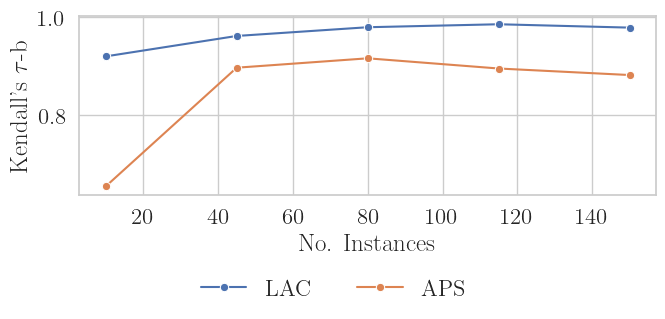

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Kendall's $\tau$-b")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
sns.lineplot(x=num_instances_to_check, y=gammas["lac"], ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(x=num_instances_to_check, y=gammas["aps"], ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_own_aps, ax = ax, marker="o",label="Reconstructed APS", linestyle="--", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_SAPS, ax = ax, marker="o", label="SAPS", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [27]:
skills_from_model = model_lac(X_test)
y_test = torch.tensor(y_test, device="cuda")
skills_from_model = skills_from_model - skills_from_model.min()
skills_from_model = skills_from_model / (skills_from_model.max() - skills_from_model.min())
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
y_test = torch.tensor(y_test, device="cuda")
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
# own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
aps_scores = oracle_annotator_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
tau_corr, p_value = kendalltau(own_aps, aps_scores)

NameError: name 'model_lac' is not defined